## Colab

In [1]:
!ls

sample_data


In [1]:
# from google.colab import files
# files.upload()

In [0]:
import zipfile
zip_ref = zipfile.ZipFile("/content/data.zip", 'r')
zip_ref.extractall(".")
zip_ref.close()

In [5]:
!ls

data  data.zip	__MACOSX  sample_data


In [0]:
!mv data/functions.py .

## Import

In [4]:
import pandas as pd
import numpy as np
from datetime import datetime
import re
from xgboost import XGBClassifier
from sklearn.ensemble import RandomForestClassifier

from sklearn.model_selection import KFold, RandomizedSearchCV, StratifiedKFold
from sklearn.metrics import roc_auc_score
import matplotlib.pyplot as plt
#from functions import *
from catboost import CatBoostClassifier
from sklearn.metrics import classification_report, f1_score

from scipy.stats import uniform as sp_randFloat
from scipy.stats import randint as sp_randInt

## Read

1. Агрегировать данные по часу
2. Создать train/test метка времени + 1/0

In [ ]:
# injuries = pd.read_csv('data/SANRAL_v2/Injuries2016_2019.csv')
# vehicles = pd.read_csv('data/SANRAL_v2/Vehicles2016_2019.csv')

In [10]:
train = pd.read_csv('data/train.csv')

In [6]:
# drop lines with bad road_segment_id
train['rs_len'] = train['road_segment_id'].apply(lambda x: len(x))
train = train[train['rs_len'] == 7]

In [7]:
dt = [datetime.strptime(x, "%d/%m/%y %H:%M") for x in train['Occurrence Local Date Time'].values]
train['dt'] = dt
train['hour_dt'] = train['dt'].dt.round('60min')

In [8]:
train['longitude'] = train['longitude'].astype(float)

In [11]:
train.head(10)

,EventId,Occurrence Local Date Time,Reporting Agency,Cause,Subcause,Status,longitude,latitude,road_segment_id
0,60558,01/01/16 00:53,Cam,Stationary Vehicle,Vehicle On Shoulder,Closed,18.5408955032,-33.888275,S0B3CGQ
1,60559,01/01/16 00:54,CAMERA,Accident,With A Fixed Object,Closed,18.9307563219,-34.140857,RYJYAPI
2,60560,01/01/16 02:26,Law Enforcement,Accident,Multi Vehicle,Closed,18.5533575029,-33.959154,U3KP57C
3,60561,01/01/16 02:56,CAMERA,Stationary Vehicle,Vehicle On Shoulder,Closed,18.6775561589,-33.895258,RY0TRQ8
4,60562,01/01/16 03:40,CAMERA,Accident,Multi Vehicle,Closed,18.8371319682,-34.087051,8LOVJZ3
5,60564,01/01/16 06:32,NaN,Stationary Vehicle,Vehicle On Shoulder,Closed,18.6384711081,-33.885498,X4UA382
6,60565,01/01/16 07:05,camera,Accident,Single Vehicle,Closed,18.4637854567,-33.943158,0QR8FDW
7,60567,01/01/16 07:39,camera,Police and Military,Road Rage,Closed,18.6359671258,-34.002366,DZABHQW
8,60568,01/01/16 08:00,camera,Stationary Vehicle,Vehicle On Shoulder,Closed,18.6350138684,-34.002237,EKZN1VM
9,60569,01/01/16 08:44,SAPS,Accident,Single Vehicle,Closed,18.4906240725,-33.949284,H9XYX9Q


## Count feats

In [0]:
locations = train.groupby('road_segment_id').mean()[['longitude', 'latitude']].reset_index().rename(columns={'road_segment_id':'segment_id'})

In [0]:
accident_count = train.groupby('road_segment_id').count()[['EventId']].reset_index().rename(columns={'road_segment_id':'segment_id', 'EventId':'target_count'})

In [0]:
train['year'] = train['hour_dt'].dt.year
train['hour'] = train['hour_dt'].dt.hour

In [0]:
accident_count_by_year = train.groupby(['road_segment_id', 'year']).count()[['EventId']]\
                                            .reset_index()\
                                            .rename(columns={'road_segment_id':'segment_id', 'EventId':'target_count_year'})
accident_count_by_hour = train.groupby(['road_segment_id', 'hour']).count()[['EventId']].reset_index().rename(columns={'road_segment_id':'segment_id', 'EventId':'target_count_hour'})

## Create train sample

In [20]:
road_segment_id = train['road_segment_id'].unique()
agg_train = pd.DataFrame([])
agg_train['ts'] = pd.date_range(start='2016-01-01', end='2018-12-31', freq='h')
rs = [road_segment_id]*agg_train.shape[0]
agg_train['rs_list'] = rs

data = []
for i in agg_train.itertuples():
    lst = i[2]
    for col2 in lst:
        data.append([i[1], col2])

df_output = pd.DataFrame(data=data, columns=agg_train.columns) 

KeyboardInterrupt: 

In [21]:
train['road_segment_id'].nunique()

549

In [0]:
# Aggregating train

base_df = df_output.merge(train[['hour_dt', 'road_segment_id', 'EventId']], 
                          left_on=['ts', 'rs_list'], 
                          right_on=['hour_dt', 'road_segment_id'],
                          how='left')\
                   .drop(['hour_dt', 'road_segment_id'], axis=1)

In [0]:
base_df['target'] = base_df['EventId'].apply(lambda x: 0 if pd.isnull(x) else 1)

In [0]:
base_df.drop(['EventId'], axis=1, inplace=True)

In [108]:
base_df['target'].value_counts()

0    14245462
1       53738
Name: target, dtype: int64

In [27]:
53738/14245462

0.0037722890279023595

In [0]:
start = datetime.strptime('18-01-01', '%y-%m-%d')
end = datetime.strptime('18-04-01', '%y-%m-%d')

base_df['test'] = base_df['ts'].apply(lambda x: 1 if x >= start and x < end else 0)

In [116]:
base_df['test'].value_counts()

0    13124055
1     1175145
Name: test, dtype: int64

In [0]:
t1 = base_df[base_df['test']==1]
t2 = base_df[(base_df['target']==1)&(base_df['test']==0)]
t3 = base_df[(base_df['target']==0)&(base_df['test']==0)].sample(n=500000)

train_short = pd.concat((pd.concat((t1, t2)), t3)).reset_index(drop=True)

In [118]:
train_short['target'].value_counts()

0    1671633
1      53738
Name: target, dtype: int64

In [0]:
del base_df, df_output, data

In [0]:
del agg_train

## Weather

In [0]:
def weather_prep(df):
    
    df['short_time'] = df['local_time'].apply(lambda x: x[:6]+x[8:])
    dt = [datetime.strptime(x, "%d/%m/%y %H:%M") for x in [x.replace('.', '/') for x in df['short_time'].values]]
    df['dt'] = dt
    df['hour_dt'] = df['dt'].dt.round('60min')
    
    df['clouds_few'] = df['clouds'].str.lower().apply(lambda x: 1 if re.findall('(few clouds)', str(x)) else 0)
    df['clouds_broken'] = df['clouds'].str.lower().apply(lambda x: 1 if re.findall('(broken clouds)', str(x)) else 0)
        df['clouds_scattered'] = df['clouds'].str.lower().apply(lambda x: 1 if re.findall('(scattered clouds)', str(x)) else 0)
    df['about_visibility'] = df['clouds'].str.lower().apply(lambda x: 1 if re.findall('(visibility)', str(x)) else 0)
    
    df['horizontal_visibility'] = df['horizontal_visibility'].apply(hv)
    
    df['weather_rain']    = df['special_weather_phenomena'].str.lower().apply(lambda x: 1 if re.findall('(rain)', str(x)) else 0)
    df['weather_fog']     = df['special_weather_phenomena'].str.lower().apply(lambda x: 1 if re.findall('(fog)', str(x)) or re.findall('(mist)', str(x)) else 0)
    df['weather_drizzle'] = df['special_weather_phenomena'].str.lower().apply(lambda x: 1 if re.findall('(drizzle)', str(x)) else 0)
    
    df['Td'] = df['Td'].apply(hv)
    df['Td'] = df['Td'].astype(float)
    
    df['morning'] = df.hour_dt.apply(lambda x: 1 if x.hour >=0 and x.hour < 7 else 0)
    df['day']     = df.hour_dt.apply(lambda x: 1 if x.hour >=7 and x.hour < 12 else 0)
    df['evening'] = df.hour_dt.apply(lambda x: 1 if x.hour >=12 and x.hour < 19 else 0)
    
    df.drop(['local_time', 'short_time', 'dt', 'clouds', 'special_weather_phenomena'], axis=1, inplace=True)
    
    df_2 = df.groupby('hour_dt').max().reset_index()

    return df_2

In [22]:
weather = pd.read_csv('data/weather_train.csv', sep=';')
weather = weather.drop(['Unnamed: 13', 'Unnamed: 14', "W'W'", 'ff10'], axis=1)

weather_cols = ['local_time', 'temperature', 'p0', 'p', 'humidity', 'mean_wind_direction', 
                'mean_wind_speed', 'special_weather_phenomena', 'clouds', 'horizontal_visibility', 'Td']

weather.columns = weather_cols
#weather_2 = weather_prep(weather.copy())

In [24]:
weather['mean_wind_direction'].nunique()

18

In [26]:
weather['clouds']

0               No Significant Clouds
1           Few clouds (10-30%) 600 m
2           Few clouds (10-30%) 450 m
3           Few clouds (10-30%) 450 m
4        Broken clouds (60-90%) 450 m
                     ...             
28367           No Significant Clouds
28368           No Significant Clouds
28369           No Significant Clouds
28370           No Significant Clouds
28371           No Significant Clouds
Name: clouds, Length: 28372, dtype: object

In [0]:
weather_cat_cols = ['mean_wind_direction']

In [30]:
weather_2.shape

(25920, 18)

## Geo

In [0]:
#tz_2018_1 = pd.read_csv('data/cape_town-travel_zones-2018-1-All-HourlyAggregate.csv')

In [0]:
seg = pd.read_pickle('data/seg_df.pickle')

In [32]:
seg.drop(['REGION', 'geometry'], axis=1, inplace=True)
seg.head()

,ROADNO,CLASS,WIDTH,LANES,SURFTYPE,PAVETYPE,CONDITION,length_1,segment_id
0,R300,Primary,20.2,2,Paved,FLEX,Good,471.207,D1U6OOF
1,R300,Primary,20.2,2,Paved,FLEX,Good,471.207,NG4X2MD
2,R300,Primary,20.2,2,Paved,FLEX,Good,471.207,792705Z
3,R300,Primary,20.2,2,Paved,FLEX,Good,471.207,IK67XHB
4,R300,Primary,20.2,2,Paved,FLEX,Good,471.207,OWCF2MH


In [0]:
seg_cat_cols = ['ROADNO', 'CLASS', 'SURFTYPE', 'PAVETYPE', 'CONDITION']

## Uber data

In [0]:
# q1_2018 = pd.read_csv('data/cape_town-travel_zones-2018-1-All-HourlyAggregate.csv')

# q2_2018 = pd.read_csv('data/cape_town-travel_zones-2018-2-All-HourlyAggregate.csv')

# q3_2018 = pd.read_csv('data/cape_town-travel_zones-2018-3-All-HourlyAggregate.csv')

# q4_2018 = pd.read_csv('data/cape_town-travel_zones-2018-4-All-HourlyAggregate.csv')

## Feats join

In [0]:
# pol = gpd.read_file('data/cape_town_travel_zones.json')
# pd.merge(base_df, gpd.sjoin(seg, pol[['fake_gavno', 'geometry']])[['segment_id', 'fake_gavno']], on='segment_id')

In [0]:
train_short = train_short.rename(columns={'rs_list':'segment_id'})#.head(2)

In [0]:
train_2 = train_short.merge(seg, on='segment_id', how='left')\
                 .merge(weather_2, left_on='ts', right_on='hour_dt', how='left')\
                 .drop('hour_dt', axis=1)

In [0]:
train_2['year'] = train_2['ts'].dt.year
train_2['month'] = train_2['ts'].dt.month
train_2['day_of_week'] = train_2['ts'].dt.weekday_name
train_2['hour'] = train_2['ts'].dt.hour

train_2 = train_2.merge(locations, on='segment_id', how='left')\
                 .merge(accident_count, on='segment_id', how='left')\
                 .merge(accident_count_by_hour, on=['segment_id', 'hour'], how='left')\
                 .merge(accident_count_by_year, on=['segment_id', 'year'], how='left')

In [0]:
train_2 = train_2.fillna(-1)

In [143]:
train_2.head()

,ts,segment_id,target,test,ROADNO,CLASS,WIDTH,LANES,SURFTYPE,PAVETYPE,CONDITION,length_1,temperature,p0,p,humidity,mean_wind_speed,horizontal_visibility,Td,clouds_few,clouds_broken,clouds_scattered,about_visibility,weather_rain,weather_fog,weather_drizzle,morning,day,evening,year,month,day_of_week,hour,longitude,latitude,target_count,target_count_hour,target_count_year
0,2018-01-01,S0B3CGQ,0,1,N1,Primary,0.0,0,Paved,Unknown,Unknown,521.765,16.0,755.2,759.0,88.0,5.0,10.0,14.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,2018,1,Monday,0,18.541422,-33.888613,181,10.0,79.0
1,2018-01-01,RYJYAPI,0,1,N2,Primary,12.8,2,Paved,FLEX,Very Good,521.945,16.0,755.2,759.0,88.0,5.0,10.0,14.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,2018,1,Monday,0,18.931088,-34.139930,76,2.0,24.0
2,2018-01-01,U3KP57C,0,1,N2,Primary,0.0,0,Paved,Unknown,Unknown,452.679,16.0,755.2,759.0,88.0,5.0,10.0,14.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,2018,1,Monday,0,18.550771,-33.958279,170,5.0,47.0
3,2018-01-01,RY0TRQ8,0,1,R300,Primary,20.2,2,Paved,FLEX,Fair,493.974,16.0,755.2,759.0,88.0,5.0,10.0,14.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,2018,1,Monday,0,18.677475,-33.896611,40,3.0,12.0
4,2018-01-01,8LOVJZ3,0,1,N2,Primary,20.2,2,Paved,FLEX,Very Good,569.263,16.0,755.2,759.0,88.0,5.0,10.0,14.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,2018,1,Monday,0,18.836121,-34.086109,919,51.0,351.0


In [0]:
# train_2.to_pickle('data/train_2.pickle')

## Train

In [0]:
# %%time
# train_2 = pd.read_pickle('data/train_2.pickle')

In [0]:
test  = train_2[train_2['test']==1]
train = train_2[train_2['test']==0]

In [145]:
train['target'].value_counts()

0    500000
1     50226
Name: target, dtype: int64

In [146]:
test['target'].value_counts()

0    1171633
1       3512
Name: target, dtype: int64

## Catboost

In [0]:
x_cols = train.drop(['ts', 'target', 'test'], axis=1).columns
cat_cols = ['segment_id', 'ROADNO', 'CLASS', 'SURFTYPE', 'PAVETYPE', 'CONDITION', 'month', 'day_of_week', 'hour']

In [44]:
# # Create the model
# model = CatBoostClassifier(depth=4,
#                            learning_rate=0.0017210509715804845,
#                            iterations=55, 
#                            loss_function='Logloss', 
#                            verbose=False)



# model.fit(train[x_cols], train['target'], cat_features=cat_cols) # Takes about

In [149]:
model_gs = CatBoostClassifier()

parameters = {'depth'         : sp_randInt(4, 10),
              'learning_rate' : sp_randFloat(),
              'iterations'    : sp_randInt(10, 100)
              }

cv = StratifiedKFold(n_splits = 5, shuffle = True, random_state = 1)

randm = RandomizedSearchCV(estimator = model_gs, 
                           param_distributions = parameters, 
                           cv = cv, 
                           n_iter = 20, 
                           n_jobs= -1,
                           random_state = 1)
randm.fit(train[x_cols], train['target'], cat_features=cat_cols)

# Results from Random Search
print("\n========================================================")
print(" Results from Random Search " )
print("========================================================")    

print("\n The best estimator across ALL searched params:\n",
      randm.best_estimator_)

print("\n The best score across ALL searched params:\n",
      randm.best_score_)

print("\n The best parameters across ALL searched params:\n",
      randm.best_params_)

print("\n ========================================================")

0:	learn: 0.4354485	total: 569ms	remaining: 54.6s
1:	learn: 0.3290984	total: 1.13s	remaining: 53.7s
2:	learn: 0.2801764	total: 1.69s	remaining: 52.9s
3:	learn: 0.2458976	total: 2.23s	remaining: 51.8s
4:	learn: 0.2305252	total: 2.76s	remaining: 50.8s
5:	learn: 0.2086410	total: 3.28s	remaining: 49.7s
6:	learn: 0.2054877	total: 3.84s	remaining: 49.3s
7:	learn: 0.2030928	total: 4.37s	remaining: 48.6s
8:	learn: 0.2011385	total: 4.95s	remaining: 48.4s
9:	learn: 0.2001260	total: 5.47s	remaining: 47.6s
10:	learn: 0.1987862	total: 5.97s	remaining: 46.7s
11:	learn: 0.1983831	total: 6.53s	remaining: 46.3s
12:	learn: 0.1976646	total: 7.08s	remaining: 45.7s
13:	learn: 0.1968058	total: 7.65s	remaining: 45.3s
14:	learn: 0.1966005	total: 8.19s	remaining: 44.7s
15:	learn: 0.1955849	total: 8.72s	remaining: 44.1s
16:	learn: 0.1953422	total: 9.26s	remaining: 43.6s
17:	learn: 0.1940388	total: 9.81s	remaining: 43s
18:	learn: 0.1938672	total: 10.4s	remaining: 42.7s
19:	learn: 0.1937521	total: 10.9s	remaining

## Predict

In [0]:
pred = randm.predict_proba(test[x_cols])

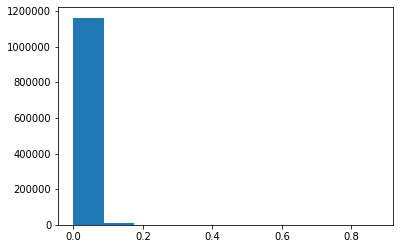

In [151]:
plt.hist(pred[:,1]);

In [152]:
roc_auc_score(test['target'], pred[:, 1])

0.8847289012317867

In [0]:
res = []
for prc in range(1, 100, 1):
    thr = np.percentile(pred[:,1], prc)
    pred_ll = [1 if x >= thr else 0 for x in pred[:, 1]]
    res.append([thr, f1_score(test['target'], pred_ll)])

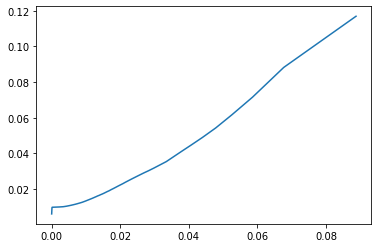

In [161]:
plt.plot([x[0] for x in sorted(res, key=lambda x: x[0], reverse=True)], 
         [x[1] for x in sorted(res, key=lambda x: x[0], reverse=True)]);

In [0]:
best_thr = sorted(res, key=lambda x: x[1], reverse=True)[0][0]
best_f1 = sorted(res, key=lambda x: x[1], reverse=True)[0][1]

In [157]:
best_thr, best_f1

(0.08877937171617549, 0.11687631027253668)

## Test prediction

In [12]:
ss = pd.read_csv('data/SampleSubmission.csv')

In [13]:
ss.head()

,datetime x segment_id,prediction
0,2019-01-01 01:00:00 x S0B3CGQ,NaN
1,2019-01-01 01:00:00 x RYJYAPI,NaN
2,2019-01-01 01:00:00 x U3KP57C,NaN
3,2019-01-01 01:00:00 x RY0TRQ8,NaN
4,2019-01-01 01:00:00 x 8LOVJZ3,NaN


In [0]:
ss_2 = ss['datetime x segment_id'].str.split(pat=' x ', expand=True).rename(columns={0:'dt', 1:'segment_id'})#.apply(pd.Series)

In [0]:
dt = [datetime.strptime(x[2:], "%y-%m-%d %H:%M:%S") for x in ss_2['dt'].values]
ss_2['dt'] = dt
ss_2['hour_dt'] = ss_2['dt'].dt.round('60min')

In [0]:
ss_2.drop(['dt'], axis=1, inplace=True)

In [57]:
ss_2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1174496 entries, 0 to 1174495
Data columns (total 2 columns):
segment_id    1174496 non-null object
hour_dt       1174496 non-null datetime64[ns]
dtypes: datetime64[ns](1), object(1)
memory usage: 17.9+ MB


### Weather

In [14]:
weather_test = pd.read_csv('data/weather_test.csv', sep=';')

weather_test = weather_test.drop(["W'W'", 'ff10'], axis=1)

weather_cols = ['local_time', 'temperature', 'p0', 'p', 'humidity', 'mean_wind_direction', 
                'mean_wind_speed', 'special_weather_phenomena', 'clouds', 'horizontal_visibility', 'Td']

weather_test.columns = weather_cols
weather_test_2 = weather_prep(weather_test.copy())

NameError: name 'weather_prep' is not defined

In [19]:
weather_test.head(3)

,local_time,temperature,p0,p,humidity,mean_wind_direction,mean_wind_speed,special_weather_phenomena,clouds,horizontal_visibility,Td
0,31.03.2019 23:00,16.0,761.2,765.0,83,Wind blowing from the east-southeast,2,NaN,Few clouds (10-30%) 720 m; broken clouds (60-9...,10.0 and more,13.0
1,31.03.2019 22:00,16.0,760.5,764.3,83,variable wind direction,2,NaN,Scattered clouds (40-50%) 690 m; broken clouds...,10.0 and more,13.0
2,31.03.2019 21:03,15.0,760.5,764.3,88,variable wind direction,1,NaN,Few clouds (10-30%) 300 m; broken clouds (60-9...,10.0 and more,13.0


### Join

In [0]:
test_1 = ss_2.merge(seg, on='segment_id', how='left')

In [0]:
test_2 = test_1.merge(weather_test_2, left_on='hour_dt', right_on='hour_dt', how='left')#.drop('hour_dt', axis=1)

In [0]:
test_2['year'] = test_2['hour_dt'].dt.year
test_2['month'] = test_2['hour_dt'].dt.month
test_2['day_of_week'] = test_2['hour_dt'].dt.weekday_name
test_2['hour'] = test_2['hour_dt'].dt.hour

test_2 = test_2.merge(locations, on='segment_id', how='left')\
                 .merge(accident_count, on='segment_id', how='left')\
                 .merge(accident_count_by_hour, on=['segment_id', 'hour'], how='left')\
                 .merge(accident_count_by_year, on=['segment_id', 'year'], how='left')

In [0]:
test_2 = test_2.fillna(-1)

In [172]:
test_2.shape

(1174496, 64)

In [0]:
test_2['test'] = [0]*test_2.shape[0]

In [0]:
pred_test = randm.predict_proba(test_2[x_cols])

In [179]:
pred_test_l = [1 if x >= best_thr else 0 for x in pred_test[:, 1]]
best_thr

0.08877937171617549

In [0]:
ss['prediction'] = pred_test_l

In [181]:
ss.shape, len(pred_test)

((1174496, 2), 1174496)

In [182]:
sum(pred_test_l)

330

In [0]:
ss.to_csv('data/submission_4.csv', index=False)

In [0]:
from google.colab import files
files.download('data/submission_4.csv') 

## Feature selection

In [0]:
X = train.drop(['ts', 'segment_id', 'EventId', 'target'], axis=1)
y = train['target'].values

In [0]:
# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 200, stop = 2000, num = 10)]
# Number of features to consider at every split
max_features = ['auto', 'sqrt']
# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]
max_depth.append(None)
# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4]
# Method of selecting samples for training each tree
bootstrap = [True, False]

# Create the random grid
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}

print(random_grid)

{'n_estimators': [200, 400, 600, 800, 1000, 1200, 1400, 1600, 1800, 2000], 'max_features': ['auto', 'sqrt'], 'max_depth': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 110, None], 'min_samples_split': [2, 5, 10], 'min_samples_leaf': [1, 2, 4], 'bootstrap': [True, False]}


In [0]:
rf = RandomForestClassifier()

In [0]:
# Задаем схему кросс-валидации
cv = StratifiedKFold(n_splits=3, shuffle=True, random_state=123)
rf_random = RandomizedSearchCV(estimator=rf, 
                               param_distributions=random_grid, 
                               n_iter=5, 
                               cv=cv, 
                               scoring='roc_auc',
                               verbose=3, 
                               random_state=1, 
                               n_jobs=2)

rf_random.fit(X, y)

Fitting 3 folds for each of 5 candidates, totalling 15 fits


[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  15 out of  15 | elapsed: 21.2min finished


RandomizedSearchCV(cv=StratifiedKFold(n_splits=3, random_state=123, shuffle=True),
                   error_score='raise-deprecating',
                   estimator=RandomForestClassifier(bootstrap=True,
                                                    class_weight=None,
                                                    criterion='gini',
                                                    max_depth=None,
                                                    max_features='auto',
                                                    max_leaf_nodes=None,
                                                    min_impurity_decrease=0.0,
                                                    min_impurity_split=None,
                                                    min_samples_leaf=1,
                                                    min_samples_split=2,
                                                    min_weight_...
                   param_distributions={'bootstrap': [True, False],
      

In [0]:
rf_random.best_score_

0.8271106880805453

In [0]:
rf_random.best_estimator_

RandomForestClassifier(bootstrap=False, class_weight=None, criterion='gini',
                       max_depth=40, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=4, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=800,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

In [0]:
pred = rf_random.predict_proba(test.drop(['ts', 'segment_id', 'EventId', 'target'], axis=1))

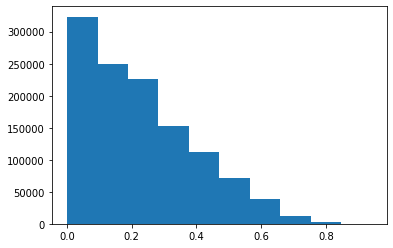

In [0]:
plt.hist(pred[:,1]);

In [0]:
roc_auc_score(test['target'], pred[:, 1])

0.7550230491867387

In [0]:
from sklearn.metrics import classification_report, f1_score

In [0]:
res = []
for prc in range(1, 100, 1):
    thr = np.percentile(pred[:,1], prc)
    pred_ll = [1 if x >= thr else 0 for x in pred[:, 1]]
    res.append([thr, f1_score(test['target'], pred_ll)])

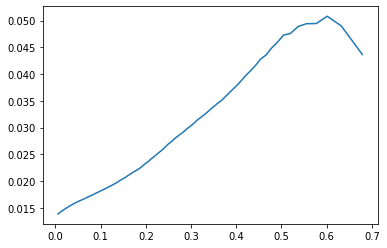

In [0]:
plt.plot([x[0] for x in sorted(res, key=lambda x: x[0], reverse=True)], [x[1] for x in sorted(res, key=lambda x: x[0], reverse=True)])

In [0]:
best_thr = sorted(res, key=lambda x: x[1], reverse=True)[0][0]
best_f1 = sorted(res, key=lambda x: x[1], reverse=True)[0][1]
best_thr

0.6012600192098999

In [0]:
best_f1 = sorted(res, key=lambda x: x[1], reverse=True)[0][1]
best_f1

0.05081231344133797